In [29]:
%matplotlib inline
# import necessary libraries and specify that graphs should be plotted inline. 
from sklearn import tree
from sklearn import neighbors, datasets
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, fbeta_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikitplot as skplt
from sklearn.metrics import classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Data Exploratory & Proprocessing

In [4]:
columns=['ID','diagnosis','radius_mean','texture_mean','perimeter_mean',
         'area_mean','smoothness_mean',
         'compactness_mean','concavity_mean','concave points_mean',
         'symmetry_mean','fractal_dimension_mean',
         'radius_se','texture_se','perimeter_se','area_se',
         'smoothness_se','compactness_se','concavity_se',
         'concave points_se','symmetry_se','fractal_dimension_se',
         'radius_worst','texture_worst','perimeter_worst',
         'area_worst','smoothness_worst','compactness_worst',
         'concavity_worst','concave points_worst',
         'symmetry_worst','fractal_dimension_worst']
data=pd.read_csv('wdbc.data.csv',header=None,names=columns)

In [5]:
# Explore the data set
n_samples, n_features = data.shape
print ('The dimensions of the data set are', n_samples, 'by', n_features) # It is made of 569 observations, each described by 30 features 
print('The classes are: ', data.diagnosis.unique())
print('The features in the data set are:', data.iloc[:, 2:].columns)

The dimensions of the data set are 569 by 32
The classes are:  ['M' 'B']
The features in the data set are: Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


In [6]:
# set up model features and output
X = data.drop(['diagnosis','ID'], axis=1) 
y = data['diagnosis']
# Encode target to binary
y = (y =='M').astype('int')

### 1. Split Data into Training and Testing Sets

In [7]:
# Doing training test split on the data.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                stratify=y,
                                                test_size=0.2,
                                                random_state=42)

### 2. Basic Data Exploration
Dataset contain 569 rows and 32 columns. ‘Diagnosis’ is the column which we are going to predict , which says if the cancer is M = malignant or B = benign. 1 means the cancer is malignant and 0 means benign. We can identify that out of the 569 persons, 357 are labeled as B (benign) and 212 as M (malignant).

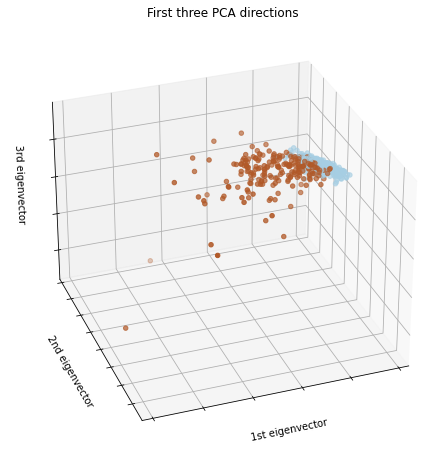

In [27]:
#### Data Visualization
# To getter a better understanding of interaction of the dimensions 
# plot the first three PCA dimensions

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(X) 
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2],
           c=y, cmap=plt.cm.Paired)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

Looking at the density of 3d points in the plot above, it does look like the malignant data points lie in a different regime than the benign ones (could be linearly separable in even more high dimensional areas)

Since there are 30 features to deal with, to start with we drop the features that are highly correlated. Using a threshold of 0.8 to figure out the correlated pairs.

<AxesSubplot:>

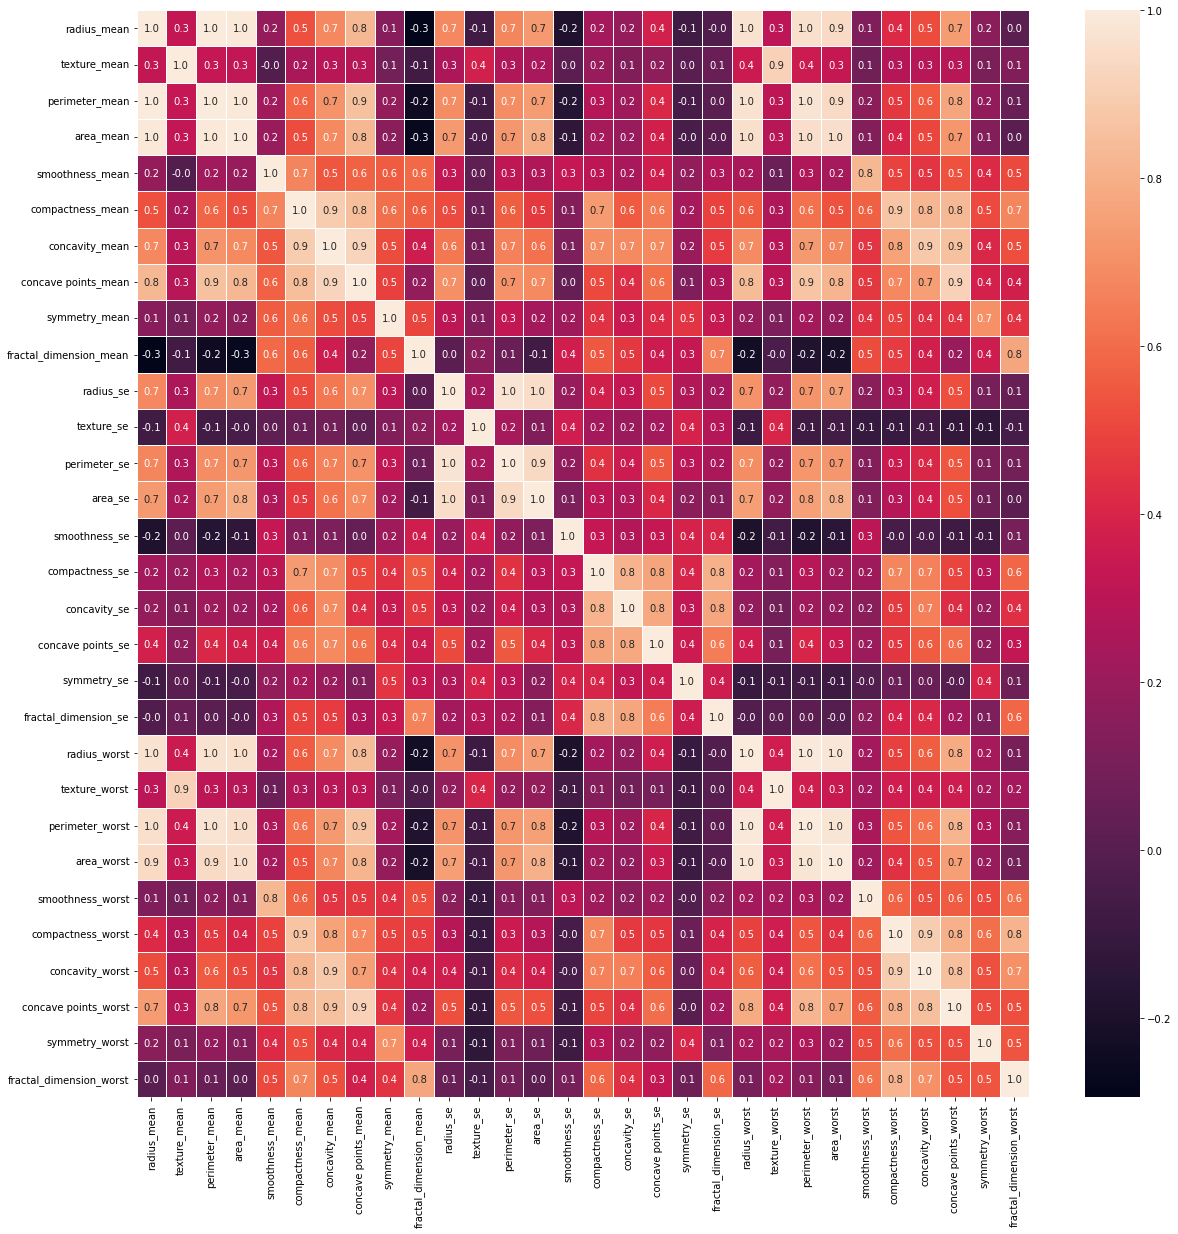

In [30]:
#Exploring the training data
f,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(X_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Identifying Correlated Pairs : This plot shows lot of features are highly correlated pairs : 1) radius_mean, perimeter_mean , area_mean 2) Compactness_mean, concavity_mean , concave_points_mean 3) radius_se, perimeter_se, area_se 4) radius_worst, perimeter_worst, area_worst 5) Compactness_worst, concavity_worst ,concave_points_worst 6) Compactness_se, concavity_se and concave_points_se 7) texture_mean and texture_worst 8) area_worst and area_mean

In [31]:
dropped_columns=['perimeter_mean','area_mean','concavity_mean',
                 'concave points_mean','perimeter_se',
                 'area_se','perimeter_worst','area_worst',
                 'concavity_worst','concave points_worst',
                 'concavity_se','concave points_se',
                 'texture_worst','area_worst']

In [32]:
#Dropping the columns from all three datasets, train, test, validation
X_train = X_train.drop(dropped_columns,axis = 1 )
X_test = X_test.drop(dropped_columns,axis = 1 )

## Model Selection

**1. Choosing the performance metric**

Since in this case I feel we should pay more focus on never wanting to classify a malignant tumor as benign as that can be really dangerous and along with that we also want to maintain high precision for malignant prediction. But since misclassification cost for the first can be far far more so we would evaluate our best model using weighted F1 score as our metric.

**In this case I will be using a weighted F1 score also called F-Beta Score (placing twice the weightage on Recall than precision) and a good model would return high F-Beta Score.** We use Beta to set this weightage, Beta represents how many times recall is more important than precision.

M is coded as 1 and B as 0, while avoiding the predictions of 1 as 0, we are mainly focussing on keeping our False Negatives as low as possible. We want to pay focus on precision too, but more focus on having high recall.

In [21]:
# prepare for nested CV
inner_cv = KFold(n_splits=5,shuffle = True,random_state = 42) 
outer_cv = KFold(n_splits=5,shuffle = True,random_state = 42)
scoring = make_scorer(fbeta_score, beta=2)

**2. Create model hyper-parameter setting for latter model selection and tuning**

In [12]:
# Initialiazing dtree and creating a dt_grid for its various hyperparameters
dt = tree.DecisionTreeClassifier()

dt_grid = {
    "max_depth" : list(range(5,10)), 
    "max_leaf_nodes": list(range(5,20)), 
    "min_samples_leaf": list(range(5,15))
}

In [33]:
# scale features for knn
# For knn, feature range should in 0 to 1
# use MinMaxScaler

scaler = MinMaxScaler()
std_scale=scaler.fit(X_train)
X_train_std =std_scale.transform(X_train) 
X_test_std = std_scale.transform(X_test)

# Initialiazing knn and creating a knn_grid for its various hyperparameters
knn = neighbors.KNeighborsClassifier()
knn_grid ={
    "weights" : ["uniform", "distance"], 
    "n_neighbors": list(range(1,20))
}

In [15]:
# Initialiazing logistic regression and creating a lr_grid for its various hyperparameters
lr = linear_model.LogisticRegression()

lr_grid ={
    "C": [0.001,0.01,0.1,1,10,100,1000], 
    "max_iter": list(range(10000, 100000))
}

In [16]:
# Initialiazing SVC and creating a svc_grid for its various hyperparameters
svc = SVC()

svc_grid ={ 
    "gamma":[0.001,0.1,1,10,100], 
    "C": [0.001,0.01,0.1,1,10]
}

**3. conduct nested cross-validation for model selection**

In [40]:
## nested CV
# non-nested parameter search and scoring
dt_clf = RandomizedSearchCV(estimator = dt, param_distributions=dt_grid, scoring=scoring, n_iter=20, cv = inner_cv)
knn_clf = RandomizedSearchCV(estimator = knn, param_distributions=knn_grid, scoring=scoring, n_iter=20, cv = inner_cv)
lr_clf = RandomizedSearchCV(estimator = lr, param_distributions=lr_grid, scoring=scoring, n_iter=20, cv = inner_cv)
svc_clf = RandomizedSearchCV(estimator = svc, param_distributions=svc_grid, scoring=scoring, n_iter=20, cv = inner_cv)

# nested cv with parameter optimization
dt_score = cross_val_score(dt_clf,X=X_train, y=y_train, cv=outer_cv) #dt_scores[i]=dt_score.mean()
knn_score = cross_val_score(knn_clf,X=X_train_std, y=y_train, cv=outer_cv) #knn_scores[i]=knn_score.mean()
lr_score = cross_val_score(lr_clf,X=X_train_std, y=y_train, cv=outer_cv) #lr_scores[i]=lr_score.mean()
svc_score = cross_val_score(svc_clf,X=X_train_std, y=y_train, cv=outer_cv) #svc_scores[i]=svc_score.mean()

In [41]:
# choose model with best fbeta score
print(f'average fbeta score of decision tree: {dt_score.mean():.4f}')
print(f'average fbeta score of KNN: {knn_score.mean():.4f}')
print(f'average fbeta score of logistic regression: {lr_score.mean():.4f}')
print(f'average fbeta score of SVC: {svc_score.mean():.4f}')

average fbeta score of decision tree: 0.9349
average fbeta score of KNN: 0.8893
average fbeta score of logistic regression: 0.9256
average fbeta score of SVC: 0.9271


**4. hyper-parameter tuning**

In [42]:
# decision tree have the highest average fbeta score
# conduct hyper-parameter tuning using random search to find the best hyper-parameters

dt = tree.DecisionTreeClassifier()

dt_grid = {
    "max_depth" : list(range(5,10)), 
    "max_leaf_nodes": list(range(5,20)), 
    "min_samples_leaf": list(range(5,15))
}

grid = RandomizedSearchCV(dt, dt_grid, cv = 5, scoring = scoring, n_iter = 20) 
grid.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=20,
                   param_distributions={'max_depth': [5, 6, 7, 8, 9],
                                        'max_leaf_nodes': [5, 6, 7, 8, 9, 10,
                                                           11, 12, 13, 14, 15,
                                                           16, 17, 18, 19],
                                        'min_samples_leaf': [5, 6, 7, 8, 9, 10,
                                                             11, 12, 13, 14]},
                   scoring=make_scorer(fbeta_score, beta=2))

In [43]:
# print result and best hyper-parameters
print (grid.best_score_) 
print (grid.best_params_) 
print (grid.best_estimator_)

0.9303512744311838
{'min_samples_leaf': 13, 'max_leaf_nodes': 13, 'max_depth': 9}
DecisionTreeClassifier(max_depth=9, max_leaf_nodes=13, min_samples_leaf=13)


**5. Predict and generate result**

Accuracy is :0.921
Precision: 0.971
Recall: 0.810
F1 Score: 0.883
Fbeta Score: 0.837
[[71  1]
 [ 8 34]]


Text(72.24000000000001, 0.5, 'Predicted Class')

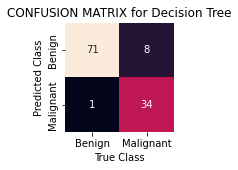

In [45]:
# leverage above trained model on testing dataset to evaluate out-of-sample performance

y_pred = grid.predict(X_test)
y_proba = grid.predict_proba(X_test)
print('Accuracy is :%.3f' %accuracy_score(y_test,y_pred)) 
print('Precision: %.3f' % precision_score(y_test, y_pred)) 
print('Recall: %.3f' % recall_score(y_test, y_pred)) 
print('F1 Score: %.3f' % f1_score(y_test, y_pred))
print('Fbeta Score: %.3f' % fbeta_score(y_test, y_pred, beta=2))
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred) 
print(conf_matrix)

fig, ax = plt.subplots(figsize=(4,2))
mat=confusion_matrix(y_test,y_pred) 
sns.heatmap(mat.T,ax=ax,square=True,annot=True, 
            xticklabels=['Benign','Malignant'], 
            yticklabels=['Benign','Malignant'],
            fmt='d',cbar=False) 
plt.title('CONFUSION MATRIX for Decision Tree')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')

No Skill: ROC AUC=0.500
decision tree: ROC AUC=0.898


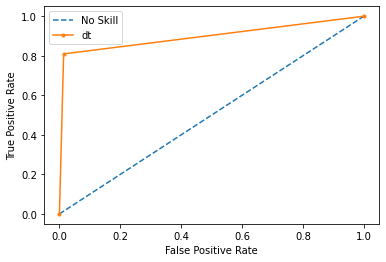

In [47]:
#ROC curve
y_pred = grid.predict(X_test)
ns_probs = [0 for _ in range(len(y_test))]

#ROC curve
ns_auc = roc_auc_score(y_test, ns_probs) 
dt_auc = roc_auc_score(y_test, y_pred)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc)) 
print('decision tree: ROC AUC=%.3f' % (dt_auc)) # calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill') 
plt.plot(lr_fpr, lr_tpr, marker='.', label='dt')
# axis labels
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') # show the legend
plt.legend()
# show the plot
plt.show()

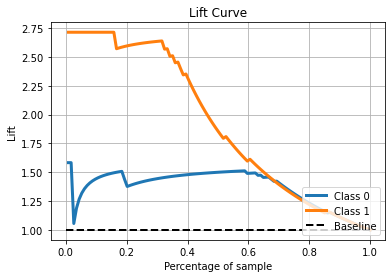

In [49]:
#Plotting LIFT curve below
skplt.metrics.plot_lift_curve(y_test, y_proba) 
plt.show()